## Assignment 3

#### By Manish Gayen 21161

In [ ]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns


In [9]:
def plot_grid_with_colors(grid_size, obstacles, goals, start_positions, agent_colors):
    fig, ax = plt.subplots(figsize=(8, 8))
    # Draw grid
    for x in range(grid_size + 1):
        ax.axhline(x, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(x, color='gray', linewidth=0.5, linestyle='--')

    # Plot obstacles
    for x, y in obstacles:
        ax.add_patch(plt.Rectangle((y, grid_size - x - 1), 1, 1, color="grey", label="Obstacle"))

    # Plot goals and agents
    for agent_id, ((gx, gy), (sx, sy)) in enumerate(zip(goals, start_positions)):
        # Plot goal with '+'
        ax.text(gy + 0.5, grid_size - gx - 1 + 0.5, '+', color=agent_colors[agent_id], fontsize=16, ha='center', va='center')
        # Plot start position with rectangle
        ax.add_patch(plt.Rectangle((sy, grid_size - sx - 1), 1, 1, color=agent_colors[agent_id], alpha=0.5,
                                   label=f"Start Agent {agent_id + 1}" if gx == gy == 0 else ""))

    # Add labels for legend (avoiding duplicates)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    #ax.legend(unique_labels.values(), unique_labels.keys())

    # Configure plot appearance
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_aspect('equal')
    ax.set_title("Initial Grid World Configuration")
    plt.show()

In [3]:
# assigning parameters

GRID_SIZE = 10
OBSTACLES = [(0,4),(1,4),(2,4),(2,5),(7,4),(7,5),(8,5),(9,5),(4,0),(4,1),(4,2),(5,2),(4,7),(4,8),(4,9),(5,7)]
GOALS = [(5,8),(5,1),(8,4),(1,5)]
START_POSITIONS = [(1,1),(8,8),(1,8),(8,1)]
AGENT_COLORS = ['blue', 'orange', 'red', 'purple']  # Unique colors for agents and goals
NUM_AGENTS = 4
ACTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0),(0,0)]  # Right, Down, Left, Up, stay at position
EPSILON = 0.1  # Exploration rate
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
MAX_STEPS = 100  # Max steps in an episode

## Initial Grid

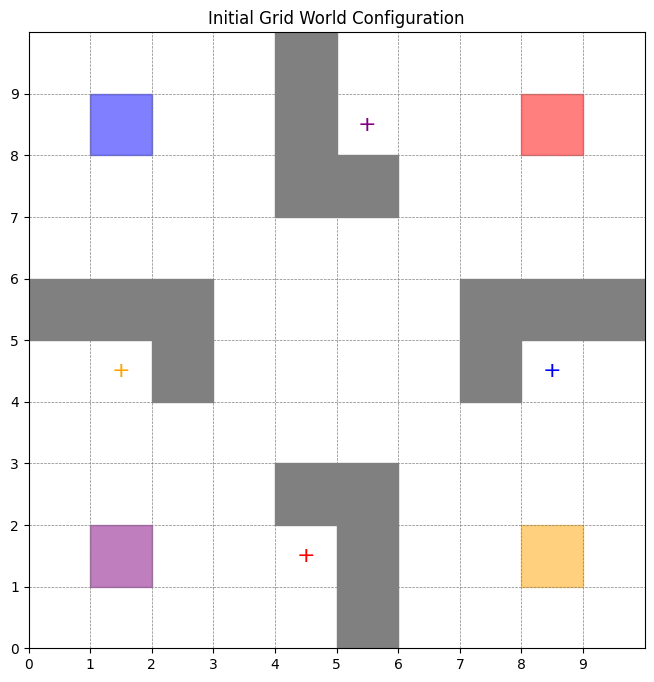

In [10]:
plot_grid_with_colors(GRID_SIZE, OBSTACLES, GOALS, START_POSITIONS, AGENT_COLORS)

## Solution:

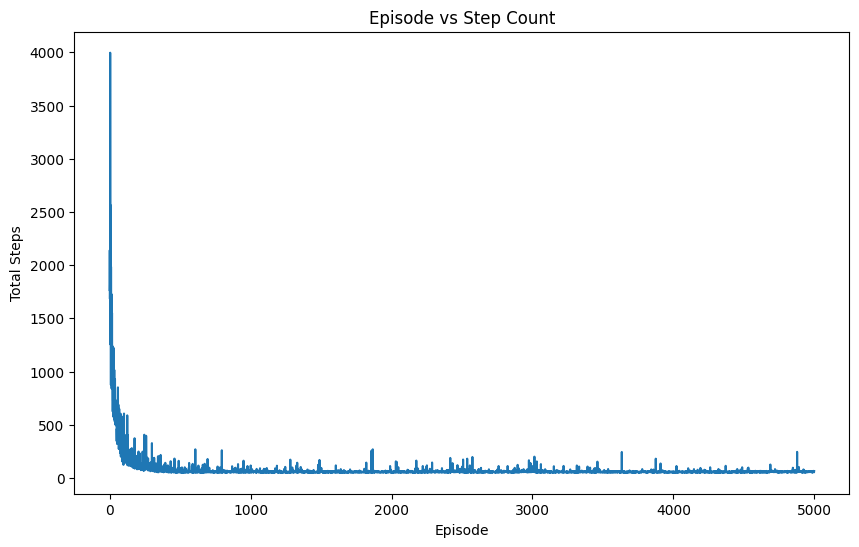

Best step count: 49


In [5]:

# Environment class
class GridWorld:
    def __init__(self, grid_size, obstacles, goals, start_positions):
        self.grid_size = grid_size
        self.obstacles = set(obstacles)
        self.goals = goals
        self.start_positions = start_positions
        self.n_agents = len(start_positions)
        self.reset()

    def reset(self):
        self.agent_positions = list(self.start_positions)
        self.done = [False] * self.n_agents
        return self.agent_positions

    def step(self, agent, action):
        if self.done[agent]:
            return self.agent_positions, 0, self.done

        moves = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1),   # right
            4: (0, 0)    # stay
        }

        current_pos = self.agent_positions[agent]
        move = moves[action]
        new_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

        # Ensure new position is within bounds
        if not (0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size):
            new_pos = current_pos

        # Ensure no collision with obstacles or other agents
        if new_pos in self.obstacles or new_pos in self.agent_positions:
            new_pos = current_pos

        # Update position and check if goal is reached
        self.agent_positions[agent] = new_pos
        if new_pos == self.goals[agent]:
            self.done[agent] = True
            return self.agent_positions, 0, self.done

        return self.agent_positions, -1, self.done

# Multi-agent Q-learning algorithm
def train_marl(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_tables = [np.zeros((env.grid_size, env.grid_size, 5)) for _ in range(env.n_agents)]
    steps_per_episode = []

    for episode in range(episodes):
        env.reset()
        total_steps = 0
        while not all(env.done):
            for agent in range(env.n_agents):
                if env.done[agent]:
                    continue

                current_pos = env.agent_positions[agent]
                x, y = current_pos

                # Epsilon-greedy action selection
                if random.uniform(0, 1) < epsilon:
                    action = random.randint(0, 4)
                else:
                    action = np.argmax(q_tables[agent][x, y])

                # Take action and observe reward and new state
                new_positions, reward, _ = env.step(agent, action)
                new_x, new_y = new_positions[agent]

                # Q-learning update
                q_tables[agent][x, y, action] += alpha * (
                    reward + gamma * np.max(q_tables[agent][new_x, new_y]) - q_tables[agent][x, y, action]
                )

                total_steps += 1

        steps_per_episode.append(total_steps)

    return q_tables, steps_per_episode
 

env = GridWorld(GRID_SIZE, OBSTACLES, GOALS, START_POSITIONS)
q_tables, steps_per_episode = train_marl(env, episodes=5000)

# Evaluate and visualize paths
paths = []
env.reset()
for agent in range(env.n_agents):
    path = [env.start_positions[agent]]
    while not env.done[agent]:
        current_pos = env.agent_positions[agent]
        x, y = current_pos
        action = np.argmax(q_tables[agent][x, y])
        env.step(agent, action)
        path.append(env.agent_positions[agent])
    paths.append(path)

# Plot steps per episode
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(steps_per_episode)), y=steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Steps')
plt.title('Episode vs Step Count')
plt.show()

print(f"Best step count: {min(steps_per_episode)}")



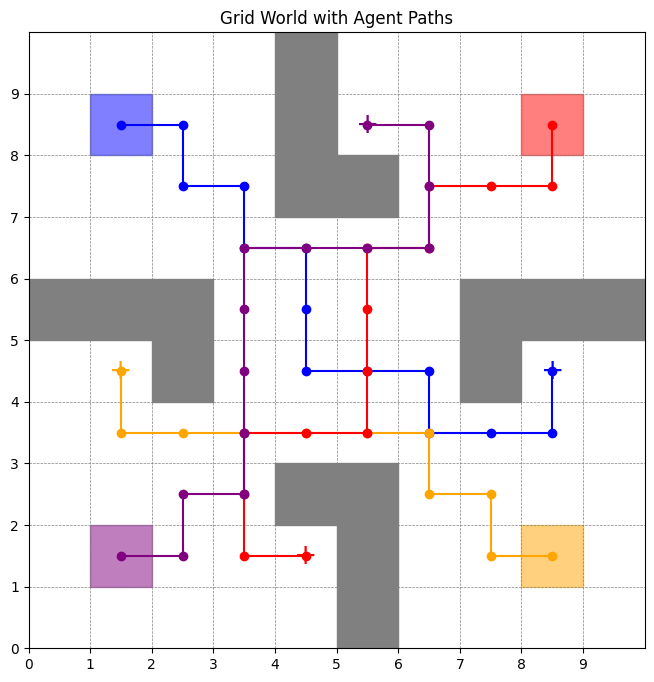

In [6]:
#function to plot the grid along with the path
def plot_grid_with_colors_and_paths(grid_size, obstacles, goals, start_positions, agent_colors, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    # Draw grid
    for x in range(grid_size + 1):
        ax.axhline(x, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(x, color='gray', linewidth=0.5, linestyle='--')

    # Plot obstacles
    for x, y in obstacles:
        ax.add_patch(plt.Rectangle((y, grid_size - x - 1), 1, 1, color="grey", label="Obstacle"))

    # Plot goals and start positions
    for agent_id, ((gx, gy), (sx, sy)) in enumerate(zip(goals, start_positions)):
        # Plot goal with '+'
        ax.text(gy + 0.5, grid_size - gx - 1 + 0.5, '+', color=agent_colors[agent_id], fontsize=20, ha='center', va='center')
        # Plot start position with rectangle
        ax.add_patch(plt.Rectangle((sy, grid_size - sx - 1), 1, 1, color=agent_colors[agent_id], alpha=0.5,
                                   label=f"Agent {agent_id + 1} Start" if gx == gy == 0 else ""))

    # Plot paths for each agent
    for agent_id, path in enumerate(paths):
        x_coords = [pos[1] + 0.5 for pos in path]
        y_coords = [grid_size - pos[0] - 1 + 0.5 for pos in path]
        ax.plot(x_coords, y_coords, marker='o', color=agent_colors[agent_id], label=f"Agent {agent_id + 1} Path")
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    #ax.legend(unique_labels.values(), unique_labels.keys())

    # Configure plot appearance
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_aspect('equal')
    ax.set_title("Grid World with Agent Paths")
    plt.show()


plot_grid_with_colors_and_paths(
    grid_size=GRID_SIZE,
    obstacles=OBSTACLES,
    goals=GOALS,
    start_positions=START_POSITIONS,
    agent_colors=AGENT_COLORS,
    paths=paths 
)


## Bonus problem solution:

In [7]:
#random start marl function
def train_marl_with_random_starts(
    env, remaining_positions, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1
):
    q_tables = [np.zeros((env.grid_size, env.grid_size, 5)) for _ in range(env.n_agents)]
    steps_per_episode = []
    last_paths = []
    last_start_positions = []
    last_episode_steps = 0  # Variable to store step count of the last episode

    for episode in range(episodes):
        # Randomly select new starting positions for agents
        random_starts = random.sample(remaining_positions, env.n_agents)
        env.start_positions = random_starts  # Update environment with random starts
        env.reset()

        # Initialize variables
        total_steps = 0
        paths = [[start] for start in env.start_positions]  # Include starting positions in paths

        while not all(env.done):
            for agent in range(env.n_agents):
                if env.done[agent]:
                    continue

                current_pos = env.agent_positions[agent]
                x, y = current_pos

                # Epsilon-greedy action selection
                if random.uniform(0, 1) < epsilon:
                    action = random.randint(0, 4)
                else:
                    action = np.argmax(q_tables[agent][x, y])

                # Take action and observe reward and new state
                new_positions, reward, _ = env.step(agent, action)
                new_x, new_y = new_positions[agent]

                # Q-learning update
                q_tables[agent][x, y, action] += alpha * (
                    reward + gamma * np.max(q_tables[agent][new_x, new_y])
                    - q_tables[agent][x, y, action]
                )

                total_steps += 1
                paths[agent].append(new_positions[agent])  # Append new position to path

        steps_per_episode.append(total_steps)

        # Save paths, start positions, and step count for the last episode
        if episode == episodes - 1:
            last_paths = paths
            last_start_positions = env.start_positions  # Store start positions for last episode
            last_episode_steps = total_steps  # Store step count of the last episode

    return q_tables, steps_per_episode, last_paths, last_start_positions, last_episode_steps

#function to get possible positions for random starts
def get_remaining_positions(grid_size, goals, obstacles):
    # Generate all coordinates in the grid
    all_positions = {(x, y) for x in range(grid_size) for y in range(grid_size)}

    # Combine obstacles and goal positions into a set
    excluded_positions = set(goals) | set(obstacles)

    # Subtract excluded positions from all positions
    remaining_positions = all_positions - excluded_positions

    return sorted(remaining_positions)

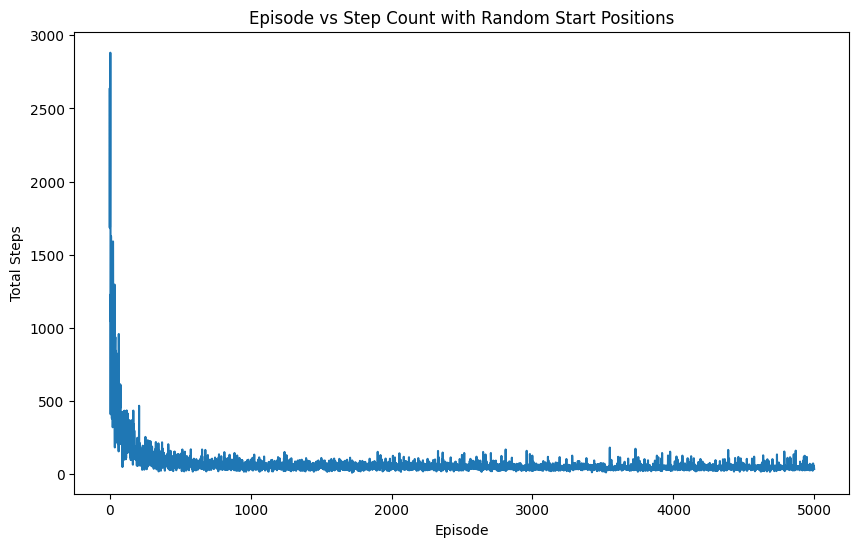

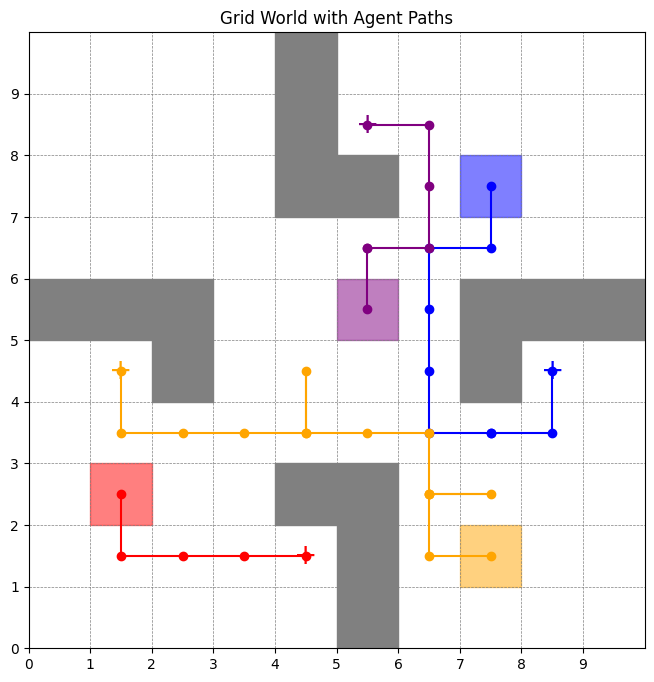

Best step count: 8,(Obtained at some initial position configuration)
Step count for the last episode: 33
Path for Agent 0: [(2, 7), (3, 7), (3, 6), (4, 6), (5, 6), (6, 6), (6, 7), (6, 7), (6, 8), (5, 8)]
Path for Agent 1: [(8, 7), (8, 6), (7, 6), (7, 7), (7, 6), (7, 6), (6, 6), (6, 5), (6, 4), (5, 4), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1)]
Path for Agent 2: [(7, 1), (8, 1), (8, 2), (8, 3), (8, 4)]
Path for Agent 3: [(4, 5), (3, 5), (3, 5), (3, 6), (2, 6), (1, 6), (1, 5)]


In [8]:
#get possible positions for random initial position
remaining_positions = get_remaining_positions(GRID_SIZE, GOALS, OBSTACLES)

# Train model
q_tables, steps_per_episode, last_paths, last_start_positions, last_episode_steps = train_marl_with_random_starts(
    env, remaining_positions, episodes=5000
)

# Plot  step count vs episode graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(steps_per_episode)), y=steps_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Steps")
plt.title("Episode vs Step Count with Random Start Positions")
plt.show()

# Visualize the paths for the last episode using last start positions
plot_grid_with_colors_and_paths(
    grid_size=GRID_SIZE,
    obstacles=OBSTACLES,
    goals=GOALS,
    start_positions=last_start_positions,  # Use the last episode's start positions
    agent_colors=AGENT_COLORS,
    paths=last_paths,
)

# print best step count, last episode step count and paths for the last episode
print(f"Best step count: {min(steps_per_episode)},(Obtained at some initial position configuration)")
print(f"Step count for the last episode: {last_episode_steps}")  # Last episode step count
for i, path in enumerate(last_paths):
    print(f"Path for Agent {i}: {path}")
